# Data
About this Data
Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization. With this dataset, it is possible to create a model to detect people wearing masks, not wearing them, or wearing masks improperly.
This dataset contains 853 images belonging to the 3 classes, as well as their bounding boxes in the PASCAL VOC format.
The classes are:

With mask;
Without mask;
Mask worn incorrectly.
How to Use this Data
Suggested Notebooks
Pytorch FasterRCNN by Daniel
More Datasets
For more datasets, click here.

How to Cite this Dataset
If you use this dataset, please credit the authors

BibTeX
@misc{make ml,
title={Mask Dataset},
url={https://makeml.app/datasets/mask},
journal={Make ML}
}

License
Public Domain

Splash Banner
Photo by engin akyurt on Unsplash

🛠️ Import Required Libraries

In [ ]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import shutil
import torch
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelEncoder

📁 Define Dataset and Output Paths

In [61]:
ANNOTATIONS_DIR = "C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/data/annotations"
IMAGES_DIR = "C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/data/images"
OUTPUT_DIR = "C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels"

📂 Create Required Folder Structure

In [62]:
os.makedirs(os.path.join(OUTPUT_DIR, 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'images', 'val'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'labels', 'train'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'labels', 'val'), exist_ok=True)

📄 Parse Annotation XML Files

In [63]:
annotations = []
for xml_file in os.listdir(ANNOTATIONS_DIR):
    tree = ET.parse(os.path.join(ANNOTATIONS_DIR, xml_file))
    root = tree.getroot()
    file_name = root.find('filename').text
    objects = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        objects.append((class_name, xmin, ymin, xmax, ymax))
    annotations.append((file_name, objects))

📊 Split Dataset into Train and Validation Sets

In [64]:
train_annotations = annotations[:int(0.8*len(annotations))]
val_annotations = annotations[int(0.8*len(annotations)):]

🔤 Encode Class Labels


In [65]:
label_encoder = LabelEncoder()
all_labels = [obj[0] for ann in annotations for obj in ann[1]]
label_encoder.fit(all_labels)

LabelEncoder()

🔄 Convert Bounding Boxes to YOLO Format

In [66]:
def convert_to_yolo_format(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[2]) / 2.0
    y = (box[1] + box[3]) / 2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

💾 Save Images and YOLO-Formatted Labels

In [67]:
def save_yolo_files(annotations, image_dir, label_dir):
    for file_name, objects in annotations:
        img_path = os.path.join(IMAGES_DIR, file_name)
        img = cv2.imread(img_path)
        h, w, _ = img.shape
        shutil.copy(img_path, image_dir)
        label_path = os.path.join(label_dir, file_name.replace('.png', '.txt'))
        with open(label_path, 'w') as f:
            for obj in objects:
                class_name, xmin, ymin, xmax, ymax = obj
                class_id = label_encoder.transform([class_name])[0]
                bb = convert_to_yolo_format((w, h), (xmin, ymin, xmax, ymax))
                f.write(f"{class_id} {' '.join(map(str, bb))}\n")

save_yolo_files(train_annotations, os.path.join(OUTPUT_DIR, 'images', 'train'), os.path.join(OUTPUT_DIR, 'labels', 'train'))
save_yolo_files(val_annotations, os.path.join(OUTPUT_DIR, 'images', 'val'), os.path.join(OUTPUT_DIR, 'labels', 'val'))

📝 Create YOLOv8 data.yaml Configuration File

In [68]:
data_yaml = f"""
train: {os.path.join(OUTPUT_DIR, 'images', 'train')}
val: {os.path.join(OUTPUT_DIR, 'images', 'val')}

nc: {len(label_encoder.classes_)}
names: {label_encoder.classes_.tolist()}
"""

with open(os.path.join(OUTPUT_DIR, 'data.yaml'), 'w') as f:
    f.write(data_yaml)

⚙️ Load Pretrained YOLOv8 Model

In [69]:
from ultralytics import YOLO

# Create a YOLOv8 model
model = YOLO('yolov8n.pt')

🚀 Train the Model

In [70]:
model.train(data=os.path.join(OUTPUT_DIR, 'data.yaml'), epochs=50, imgsz=416, batch=16, cache=True)

New https://pypi.org/project/ultralytics/8.3.137 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.145  Python-3.7.12 torch-1.13.1+cpu CPU (13th Gen Intel Core(TM) i7-13700H)
WARNING  Upgrade to torch>=2.0.0 for deterministic training.
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\data.yaml, epochs=50, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

🎯 Load Trained YOLOv8 Model

In [72]:
model = YOLO('runs/detect/train6/weights/best.pt')

🖼️ Define a Function to Visualize Predictions and Visualize Inference on Validation Images


0: 416x320 1 with_mask, 68.5ms
Speed: 1.0ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 320)


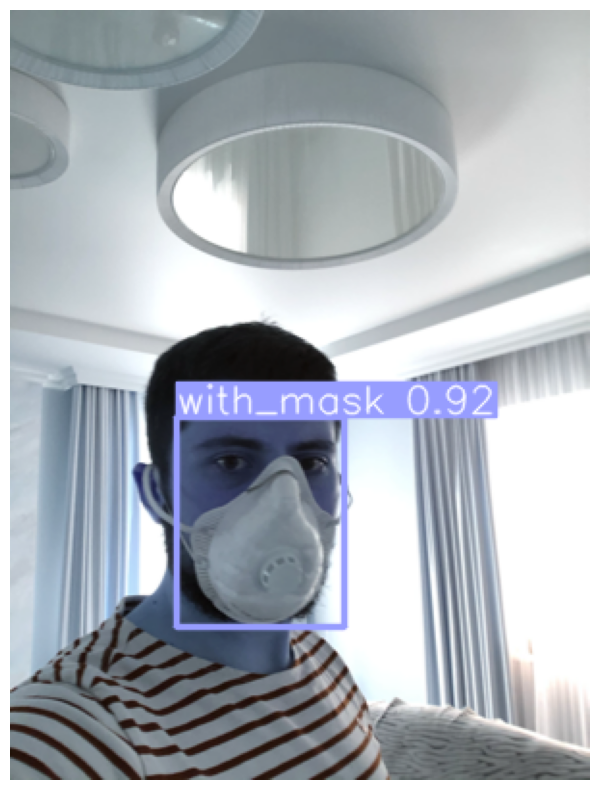


0: 320x416 2 with_masks, 69.4ms
Speed: 0.0ms preprocess, 69.4ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 416)


<class 'numpy.ndarray'> (400, 301, 3)
📂 Yüklenen görseller: ['C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss712.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss713.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss714.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss715.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss716.png']


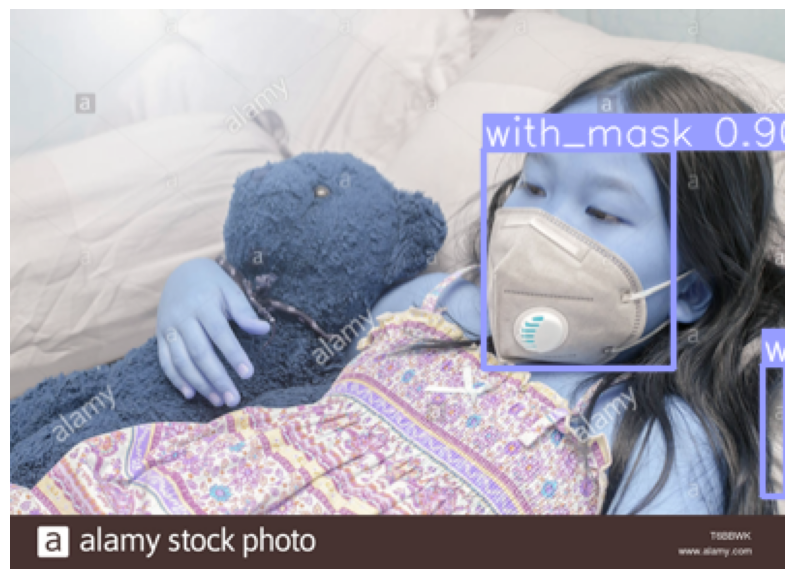


0: 320x416 4 with_masks, 54.9ms
Speed: 4.7ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 416)


<class 'numpy.ndarray'> (289, 400, 3)
📂 Yüklenen görseller: ['C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss712.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss713.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss714.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss715.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss716.png']


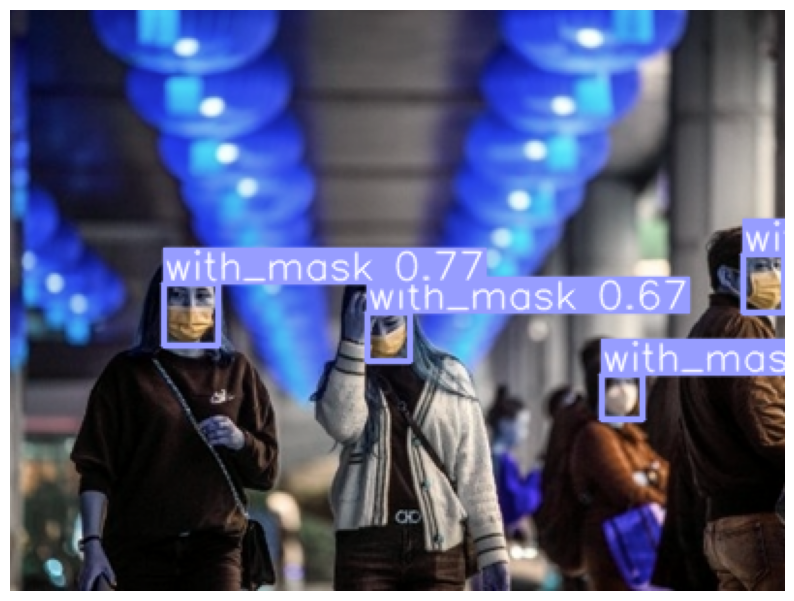


0: 416x288 1 with_mask, 1 without_mask, 100.7ms
Speed: 0.0ms preprocess, 100.7ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 288)


<class 'numpy.ndarray'> (300, 400, 3)
📂 Yüklenen görseller: ['C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss712.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss713.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss714.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss715.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss716.png']


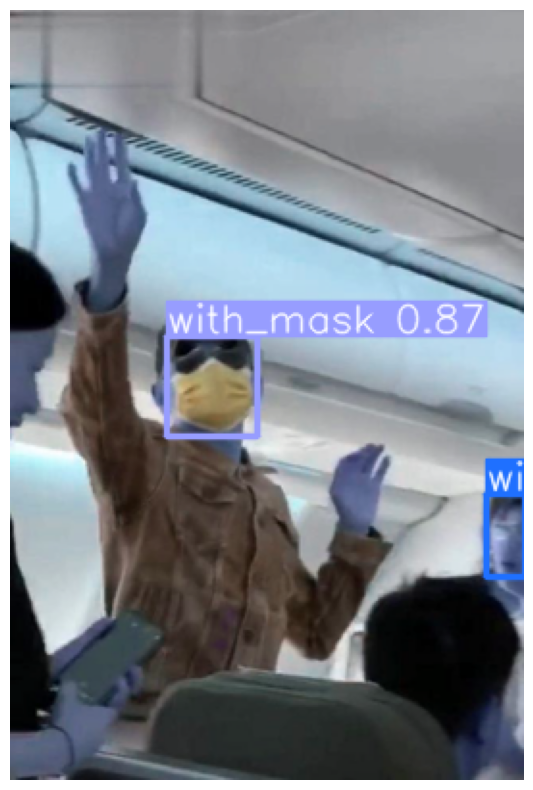


0: 416x320 1 without_mask, 50.2ms
Speed: 1.7ms preprocess, 50.2ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 320)


<class 'numpy.ndarray'> (400, 267, 3)
📂 Yüklenen görseller: ['C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss712.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss713.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss714.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss715.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss716.png']


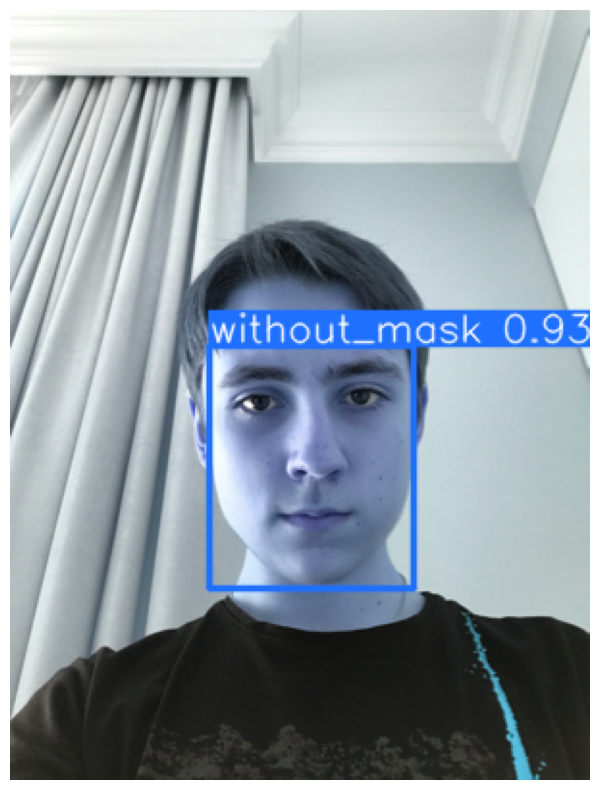

<class 'numpy.ndarray'> (400, 301, 3)
📂 Yüklenen görseller: ['C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss712.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss713.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss714.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss715.png', 'C:/Users/er_po/Desktop/Dataguess/ObjectDetectionTwoClasses/labels\\images\\val\\maksssksksss716.png']


In [73]:
%matplotlib inline

def plot_sample_images(image_dir, model, num_images=5):
    images = [os.path.join(image_dir, img) for img in os.listdir(image_dir)][:num_images]
    for img_path in images:
        img = cv2.imread(img_path)
        results = model(img)
        result_img = results[0].plot()  
        plt.figure(figsize=(10, 10))
        plt.imshow(result_img)
        plt.axis('off')
        plt.show()
        print(type(result_img), result_img.shape if hasattr(result_img, 'shape') else 'no shape')
        print("📂 Yüklenen görseller:", images)



plot_sample_images(os.path.join(OUTPUT_DIR, 'images', 'val'), model)
